## Imports

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

!gdown 1Gg562BH9hsh9qYxSnn6MqvUmpCIABpsr
!gdown 1qHUKjWfaUUJELetH655hadqZabG1AKFp
df_movies = pd.read_csv('movies.csv')
df_ratings = pd.read_csv("ratings.csv")


Downloading...
From: https://drive.google.com/uc?id=1Gg562BH9hsh9qYxSnn6MqvUmpCIABpsr
To: /content/ratings.csv
100% 2.48M/2.48M [00:00<00:00, 174MB/s]


## Data preprocessing

#### 1. Form the transactional data set, which consists of entries of the form ⟨user id, {movies rated above 2}⟩. Consider only those users who have rated more than 10 movies.


In [ ]:
# 1
df_ratings = df_ratings[df_ratings["rating"] > 2]
user_counts = df_ratings.groupby("userId")["movieId"].count()
valid_users = user_counts[user_counts > 10].index
df_ratings = df_ratings[df_ratings["userId"].isin(valid_users)]


#### 2. Divide the data set into 80% training set and 20% test set. Remove 20% of movies watched from each user and create a test set using the removed movies.

In [ ]:
# 2
train_set = {}
test_set = {}

train_data, test_data = train_test_split(df_ratings, test_size=0.2, random_state=42)

for user, group in train_data.groupby("userId"):
    train_set[user] = list(group["movieId"])

for user, group in test_data.groupby("userId"):
    test_set[user] = list(group["movieId"])

movies_train = [movie for user in train_set for movie in train_set[user]]
movies_train_unique = list(set(movies_train))


### Association Rule Mining
### Part-1

##### 1. From the training set, extract the set of all association rules of form X → Y , where X contains a single movie and Y contains the set of movies from the training set by employing the apriori or FPgrowth approach. Set some minsup and minconf (e.g., 50 and 0.1 respectively).

In [ ]:
def support(movies):
    matching_users = [
        user for user in train_set if all(movie in train_set[user] for movie in movies)
    ]
    return len(matching_users) / len(train_set)


def generate_frequent_itemsets(itemset_size, minsup, item_sets):
    frequent_itemsets = []

    if itemset_size == 2:
        candidates = [(x, y) for x in l1_movies for y in l1_movies if x < y]
    else:
        candidates_list = []
        candidate = []
        for i in range(len(item_sets)):
            for j in range(i + 1, len(item_sets)):
                if sorted(item_sets[i][:-1]) == sorted(item_sets[j][:-1]):
                    candidate = list(item_sets[i][:-1])
                    candidate.append(item_sets[i][-1])
                    candidate.append(item_sets[j][-1])
                    candidates_list.append(candidate)
    for candidate in candidates_list:
        sup = support(candidate)
        if sup >= minsup:
            frequent_itemsets.append(candidate)

    return frequent_itemsets


def generate_association_rules(item_list, minconf):
    for x in item_list:
        s = support(x)
        for i in range(len(x)):
            antecedent = [x[j] for j in range(len(x)) if j != i]
            conf = s / support(antecedent)
            if conf >= minconf:
                ass_rules.append([antecedent, [x[i]], s, conf])

    return ass_rules


In [ ]:
# minsup = 50 / len(train_set)
minsup = 0.1
minconf = 0.1

asr_movies_sup = {
    movie: support([movie])
    for movie in movies_train_unique
    if support([movie]) >= minsup
}

movies_stminsup = list(asr_movies_sup.keys())

l1_movies = movies_stminsup
l2_movies = generate_frequent_itemsets(2, minsup, l1_movies)
l3_movies = generate_frequent_itemsets(3, minsup, l2_movies)
l4_movies = generate_frequent_itemsets(4, minsup, l3_movies)


ass_rules = []


generate_association_rules(l2_movies, minconf)
generate_association_rules(l3_movies, minconf)
generate_association_rules(l4_movies, minconf)

[[[32], [1], 0.10378912685337727, 0.4666666666666667],
 [[1], [32], 0.10378912685337727, 0.3818181818181818],
 [[47], [1], 0.10214168039538715, 0.38993710691823896],
 [[1], [47], 0.10214168039538715, 0.37575757575757573],
 [[110], [1], 0.12685337726523888, 0.4117647058823529],
 [[1], [110], 0.12685337726523888, 0.4666666666666666],
 [[150], [1], 0.10049423393739704, 0.42957746478873243],
 [[1], [150], 0.10049423393739704, 0.3696969696969697],
 [[260], [1], 0.1301482701812191, 0.41361256544502617],
 [[1], [260], 0.1301482701812191, 0.47878787878787876],
 [[296], [1], 0.13509060955518945, 0.35497835497835495],
 [[1], [296], 0.13509060955518945, 0.4969696969696969],
 [[318], [1], 0.1400329489291598, 0.3469387755102041],
 [[1], [318], 0.1400329489291598, 0.5151515151515151],
 [[356], [1], 0.15815485996705106, 0.37795275590551175],
 [[1], [356], 0.15815485996705106, 0.5818181818181818],
 [[364], [1], 0.11037891268533773, 0.5234375],
 [[1], [364], 0.11037891268533773, 0.406060606060606],
 [[

### Part-2

##### 2. Recommendation: Generate two sets of lists:
##### • The initial list includes the top 100 association rules, arranged in order of their support.
##### • The second list comprises the top 100 rules, prioritizing them according to confidence.
##### • Identify the rules that appear in both lists, and then arrange these shared rules based on their confidence score.

In [ ]:
sup_rules = sorted(ass_rules, key=lambda x: x[2], reverse=True)
conf_rules = sorted(ass_rules, key=lambda x: x[3], reverse=True)

top_100_sup_rules = sup_rules[:100]
top_100_conf_rules = conf_rules[:100]

# common_sup_conf_rules = []
# for x in top_100_conf_rules:
#     if x in top_100_sup_rules:
#         common_sup_conf_rules.append(x)
# print(common_sup_conf_rules)

# top_support_rules=sorted(rules,key=lambda x: x[1],reverse=True)[:100]
# top_confidence_rules=sorted(rules,key=lambda x: x[2],reverse=True)[:100]
shared_rules = [t1 for t1 in top_100_sup_rules for t2 in top_100_conf_rules if t1 == t2]
shared_rules = sorted(shared_rules, key=lambda x: x[3], reverse=True)
# write_to_file(top_support_rules,'10_top100RulesBySup.txt')
# write_to_file(top_confidence_rules,'10_top100RulesByConf.txt')
# write_to_file(shared_rules,'4_shared_rules.txt')

with open("62_top100RulesBySup.txt", "w") as sup_file:
    for rule in top_100_sup_rules:
        sup_file.write(",".join(map(str, rule)) + "\n")

with open("62_top100RulesByConf.txt", "w") as conf_file:
    for rule in top_100_conf_rules:
        conf_file.write(",".join(map(str, rule)) + "\n")

with open("62_shared_rules", "w") as shar_file:
    for rule in shared_rules:
        shar_file.write(",".join(map(str, rule)) + "\n")

shared_rules


[[[7153], [4993], 0.18616144975288304, 0.7635135135135136], [[5952], [4993], 0.15980230642504117, 0.7519379844961239], [[1210], [260], 0.18616144975288304, 0.7337662337662338], [[1196], [260], 0.19604612850082373, 0.7300613496932515], [[4993], [7153], 0.18616144975288304, 0.7290322580645161]]


In [ ]:
# # df_movies.head()
# #map movie id to title
# dic_movie_={}
# for i in range(len(df_movies)):
#     dic_movie_[int(df_movies.iloc[i]['movieId'])]=df_movies.iloc[i]['title']

# def write_to_file(list_of_tuples,file_name):
#     lst=["Rule , Support , Confidence \n"]

#     for rule in list_of_tuples:
#         rule_X=rule[0]
#         rule_Y=rule[1]
#         support=rule[2]
#         confidence=rule[3]
#         # lst_rules=rule.split('->')
#         # A=lst_rules[0]
#         # B=lst_rules[1][2:-1]
#         # B_lst=B.split(',')
#         # recommmended_movies=[dic_movie_[int(float(id))] for id in B_lst]
#         recommmended_movies=[dic_movie_[int(float(id))] for id in rule_Y]
#         reco_str=','.join(recommmended_movies)
#         # st=dic_movie_[int(float(A))]+"-> {"+reco_str+"} , "+str(support)+" , "+str(confidence)+" \n"
#         st=dic_movie_[int(float(rule_X[0]))]+"-> {"+reco_str+"} , "+str(support)+" , "+str(confidence)+" \n"
#         lst.append(st)
#     with open(file_name,'w') as f:
#         f.writelines(lst)

# write_to_file(top_100_sup_rules,'62_top100RulesBySup1.txt')
# write_to_file(top_100_conf_rules,'62_top100RulesByConf1.txt')
# write_to_file(shared_rules,'62_shared_rules1.txt')

[[[7153], [4993], 0.18616144975288304, 0.7635135135135136],
 [[5952], [4993], 0.15980230642504117, 0.7519379844961239],
 [[1210], [260], 0.18616144975288304, 0.7337662337662338],
 [[1196], [260], 0.19604612850082373, 0.7300613496932515],
 [[4993], [7153], 0.18616144975288304, 0.7290322580645161]]

### Part-3

##### 3. For each user in the test set, select association rules of the form X → Y , where X is the movie in the training set. Compute the average precision and average recall by varying the number of rules from 1 to 10 and plot the graphs.

[0.0005491488193300384, 0.0005491488193300384, 0.0005077036254183374, 0.0004360887682915011, 0.0004236290891974582, 0.0004234633501171775, 0.00040671334431630974, 0.00040488090916706226, 0.00037985164445886074, 0.00036346540559973765]
[0.00013615259983389383, 0.00025188230969270354, 0.00033357386959303987, 0.00036761201955151337, 0.0004288806894767656, 0.0004969569893937125, 0.0005378027693438807, 0.0005922638092774382, 0.0006058790692608276, 0.0006263019592359116]


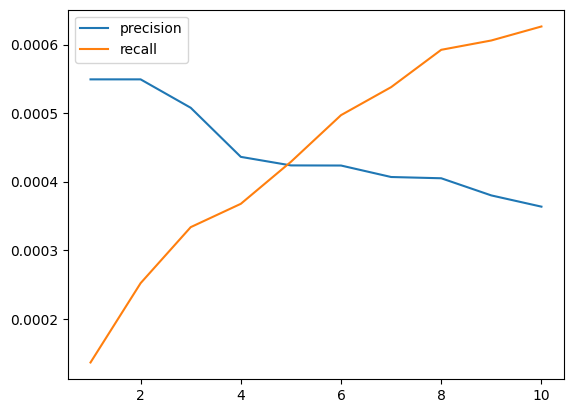

In [ ]:
precision_avgs = []
recall_avgs = []
recall_sum = 0
precision_sum = 0
for k in range(1, 11):
    print(k)
    for user in train_set:
        train = train_set[user]
        if user in test_set:
            test = test_set[user]
            recall_sum = 0
            precision_sum = 0
            recommendation = []
            for x in train:
                y = []
                count = 0
                for asr in conf_rules:
                    if int(asr[0][0]) == int(x):
                        y += asr[1]
                        count += 1
                        if count == k:
                            break
                recommendation += y
            hitset = []
            for m in recommendation:
                if m in test:
                    hitset.append(m)
            recall = len(hitset) / len(test)
            if len(recommendation) == 0:
                precision = 0
            else:
                precision = len(hitset) / len(recommendation)
            recall_sum += recall
            precision_sum += precision
    recall_avg = recall_sum / len(train_set)
    precision_avg = precision_sum / len(train_set)
    precision_avgs.append(precision_avg)
    recall_avgs.append(recall_avg)

print(precision_avgs)
print(recall_avgs)

x = [i for i in range(1, 11)]
plt.plot(x, precision_avgs, label="precision")
plt.plot(x, recall_avgs, label="recall")
plt.legend()


Decreasing Precision: On increasing the number of rules (k), the average precision is likely to decrease. This is because with more rules, we are recommending a larger set of items, and some of those recommendations may not be relevant to the user. As a result, the precision, which measures how many of the recommended items are relevant, tends to decrease as k increases.

Increasing Recall: On the other handOn increasing the number of rules (e) N, the average recall is likely to increase. This is because with more rulesweou are recommending a larger set of items, which is more likely to include some of the relevant items from the test set. Recall measures how many of the relevant items are included in the recommendations, and aweou provide more recommendationsweou are more likely to cover a larger portion of the relevant items.

Trade-off Between Precision and Recall: The graph will likely show a trade-off between precision and recall. Wwe you have fewer rules (loker we you have a higher precision but a lower recall, and wwe you have more rules (higker we you have a higher recall but a lower precisces.

### Part-4
##### 4. Take a sample example of users and their movie ratings from the test set and display precision and recall graphs.

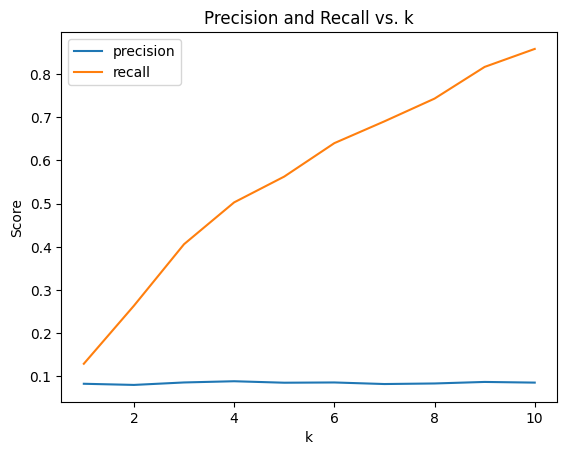

In [ ]:
sample_size = 20
sample_users = random.sample(list(test_set.keys()), sample_size)

precision_avgs = []
recall_avgs = []

for k in range(1, 11):
    recall_sum = 0
    precision_sum = 0

    for user in sample_users:
        train = train_set[user]
        if user in test_set:
            test = test_set[user]
            recommendation = []

            for x in train:
                y = []
                count = 0
                for asr in conf_rules:
                    if int(asr[0][0]) == int(x):
                        y = y + asr[1]
                        count += 1
                        if count == k:
                            break
                recommendation = recommendation + y

            hit_set = [m for m in recommendation if m in test]

            recall = len(hit_set) / len(test)
            precision = (
                len(hit_set) / len(recommendation) if len(recommendation) > 0 else 0
            )

            recall_sum += recall
            precision_sum += precision

    recall_avg = recall_sum / sample_size
    precision_avg = precision_sum / sample_size

    precision_avgs.append(precision_avg)
    recall_avgs.append(recall_avg)

x = [i for i in range(1, 11)]
plt.plot(x, precision_avgs, label="precision")
plt.plot(x, recall_avgs, label="recall")
plt.legend()
plt.xlabel("k")
plt.ylabel("Score")
plt.title("Precision and Recall vs. k")
plt.show()


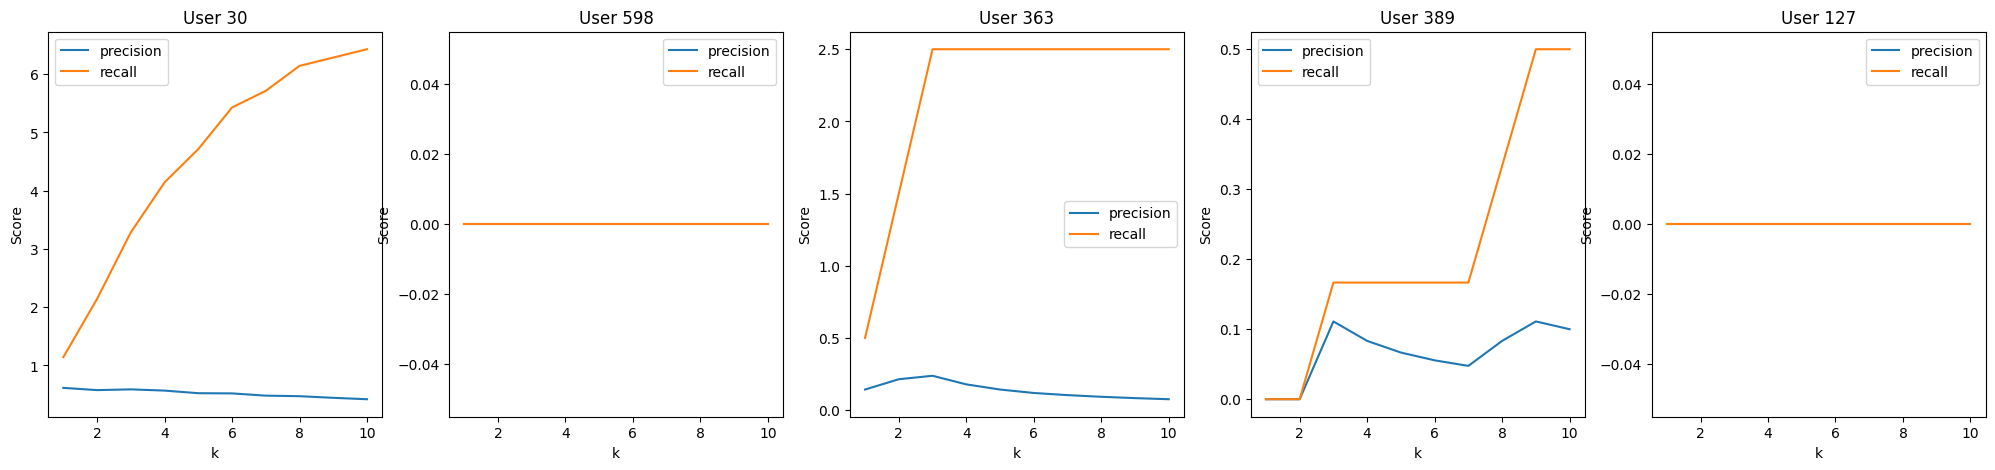

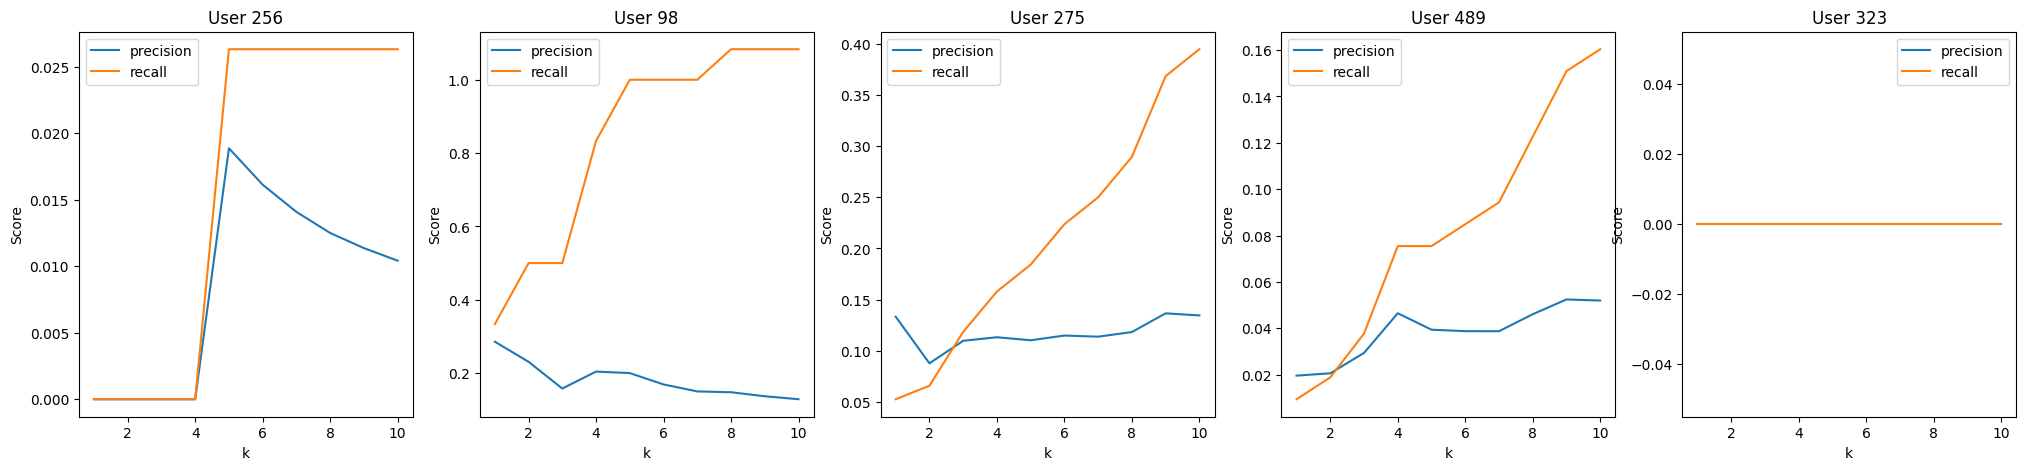

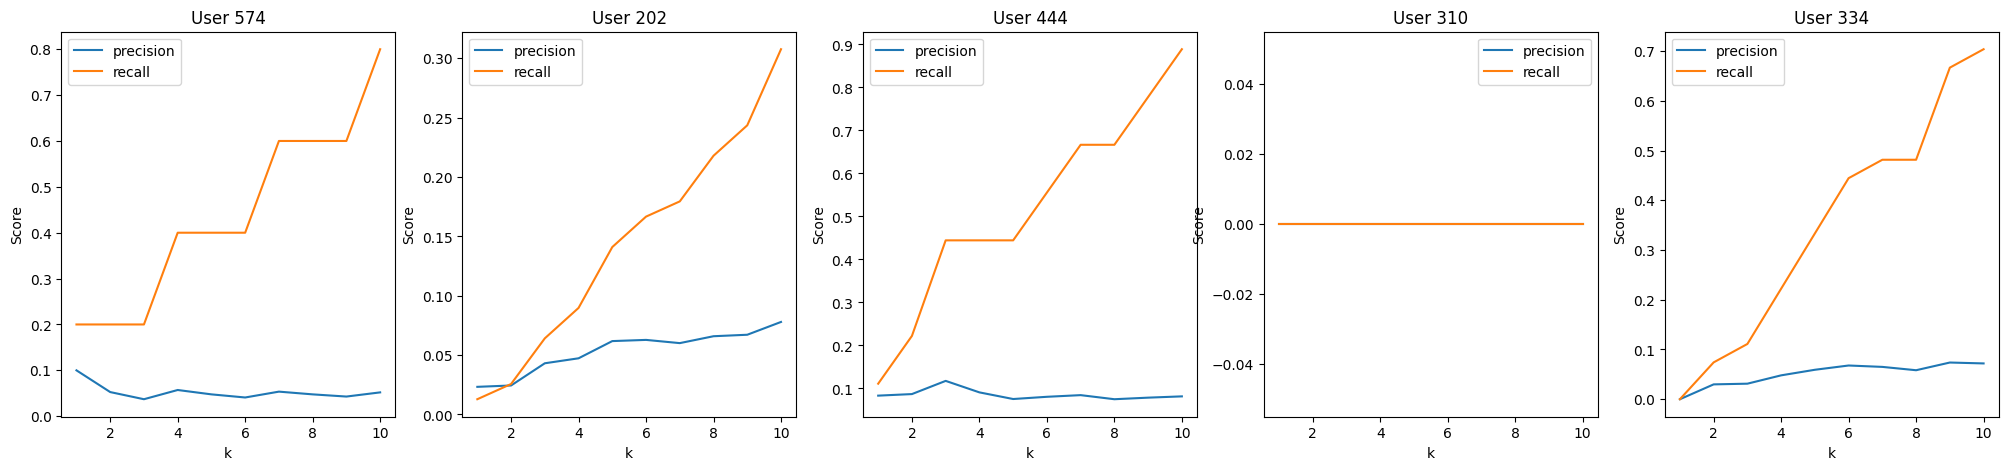

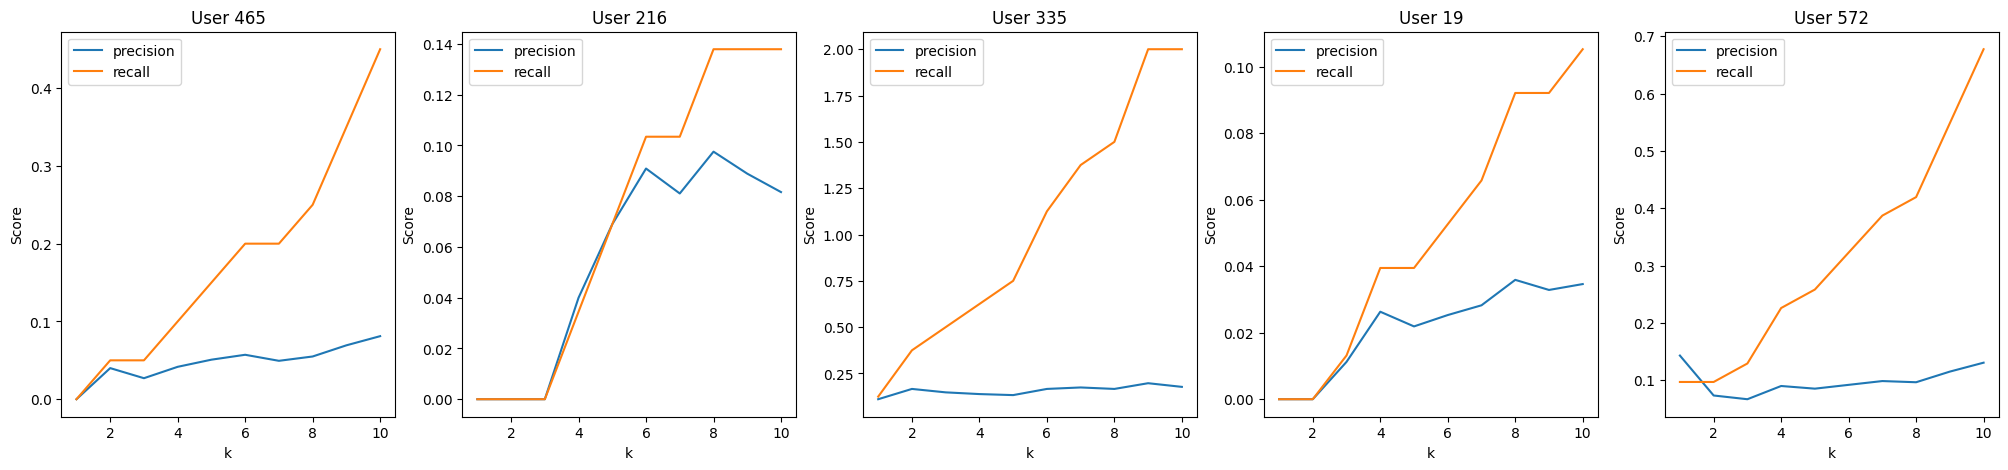

In [ ]:
users_per_row = 5
num_rows = (sample_size + users_per_row - 1) // users_per_row

for row in range(num_rows):
    plt.figure(figsize=(25, 5))

    for col in range(users_per_row):
        index = row * users_per_row + col
        if index >= sample_size:
            break

        user = sample_users[index]
        precision_avgs = []
        recall_avgs = []

        for k in range(1, 11):
            train = train_set[user]
            if user in test_set:
                test = test_set[user]
                recall_sum = 0
                precision_sum = 0
                recommendation = []

                for x in train:
                    y = []
                    count = 0
                    for asr in conf_rules:
                        if int(asr[0][0]) == int(x):
                            y = y + asr[1]
                            count += 1
                            if count == k:
                                break
                    recommendation = recommendation + y

                hit_set = [m for m in recommendation if m in test]

                recall = len(hit_set) / len(test)
                precision = (
                    len(hit_set) / len(recommendation) if len(recommendation) > 0 else 0
                )

                recall_sum += recall
                precision_sum += precision

            recall_avg = recall_sum
            precision_avg = precision_sum

            precision_avgs.append(precision_avg)
            recall_avgs.append(recall_avg)

        x = [i for i in range(1, 11)]
        plt.subplot(1, users_per_row, col + 1)
        plt.plot(x, precision_avgs, label="precision")
        plt.plot(x, recall_avgs, label="recall")
        plt.xlabel("k")
        plt.ylabel("Score")
        plt.title(f"User {user}")
        plt.legend()

    plt.show()
